In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

from src.graph_models.csbm import CSBM
from src.models.ntk import NTK
from src.attacks import create_attack
from common import configure_hardware, get_graph, get_diffusion, row_normalize, count_edges_for_idx

ImportError: cannot import name 'get_diffusion' from 'common' (/ceph/ssd/staff/gosl/src/ntk-robust/common.py)

In [3]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    #n_per_class_trn = 400
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
)
K_l = [0.1, 0.5, 1, 1.5, 2, 5],
seed = 42
# Model
model_dict_gcn = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 1,
}
model_dict_softmedoid = {
    "label": "SoftMedoid",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 50
}
model_dict = model_dict_softmedoid
model_dict_l = [model_dict_gcn, model_dict_softmedoid]
attack_params = {
    "attack": "noise"
}
# Attack
eps_l = [0, 0.01, 0.025, 0.05, 0.10, 0.25, 0.50, 1, 2.5, 5, 10]
# other
device = "cpu"
dtype = torch.float64


In [4]:
torch.set_printoptions(profile="full")
torch.set_printoptions(profile="default")
K = 1
device_ = configure_hardware(device, seed)
data_dict["K"] = 1
X, A, y = get_graph(data_dict, seed)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
n = X.shape[0]
d = X.shape[1]
X_view = X.view(1, n, d)
dist = torch.cdist(X_view, X_view, p=2).view(n, n)
A_self = A + torch.eye(n)
print(dist)
print(A_self @ dist)
print(- (1 / model_dict["T"]) * A_self @ dist)
S = torch.exp(- (1 / model_dict["T"]) * (A_self @ dist))
print(S)
#print(torch.einsum("ij,ij->i", A_self, S))
normalization = torch.einsum("ij,ij->i", A_self, S)
#print(normalization)
#S = torch.einsum("ij, i -> ij", S, normalization)
S = (S*A_self) / normalization[:, None]
print(torch.max(S))
print(torch.min(S))
torch.set_printoptions(profile="default")

tensor([[0.0000, 5.9556, 7.0282,  ..., 7.0024, 7.3590, 6.8520],
        [5.9556, 0.0000, 7.3833,  ..., 6.5958, 7.5845, 6.3994],
        [7.0282, 7.3833, 0.0000,  ..., 5.6085, 7.1332, 7.2598],
        ...,
        [7.0024, 6.5958, 5.6085,  ..., 0.0000, 5.4770, 6.0525],
        [7.3590, 7.5845, 7.1332,  ..., 5.4770, 0.0000, 6.9866],
        [6.8520, 6.3994, 7.2598,  ..., 6.0525, 6.9866, 0.0000]],
       dtype=torch.float64)
tensor([[34.1162, 41.4347, 40.0769,  ..., 39.3459, 42.5220, 35.4682],
        [33.4983, 25.7927, 32.9584,  ..., 29.3758, 34.9704, 30.9123],
        [26.6347, 27.6402, 17.5625,  ..., 21.9333, 24.4963, 23.4730],
        ...,
        [21.8708, 27.0002, 24.5651,  ..., 17.5515, 24.5364, 23.6390],
        [19.2687, 21.8804, 21.0855,  ..., 19.0618, 14.4039, 18.6258],
        [13.2209, 13.3082, 13.7554,  ..., 10.4833, 14.1679,  5.4947]],
       dtype=torch.float64)
tensor([[-0.6823, -0.8287, -0.8015,  ..., -0.7869, -0.8504, -0.7094],
        [-0.6700, -0.5159, -0.6592,  ..., 

# K_l comparison

In [27]:
ntk_dict = dict()
K_l = [1]
device_ = configure_hardware(device, seed)
for K in K_l:
    # Sample
    X, A, y = get_graph()
    X = torch.tensor(X, dtype=dtype, device=device_)
    A = torch.tensor(A, dtype=dtype, device=device_)
    y = torch.tensor(y, device=device_)
    target_idx = np.arange(A.shape[0])
    S = get_diffusion(X, A, model_dict)
    # Init Attack
    attack = create_attack(target_idx, X, A, y, {"attack":"noise"}, seed)
    # Computing NTK
    ntk_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A, target_idx)))
        A_pert = attack.attack(n_pert)
        S = get_diffusion(X, A_pert, model_dict)
        ntk_l.append(NTK(X, S, model_dict))
    ntk_dict[K] = ntk_l

1


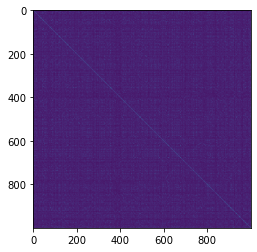

In [11]:
ntk_l = ntk_dict[1]
ntk = ntk_l[10].get_ntk().detach().cpu().numpy()
fig, ax = plt.subplots()
im = ax.imshow(ntk)


In [12]:
def calc_kernel_means(ntk: NTK, n_class0: int):
    ntk = ntk.get_ntk()
    mask_class0 = torch.zeros((n,n), dtype=torch.bool)
    mask_class0[:n_class0, :n_class0] = True
    mask_class0 = mask_class0.triu(diagonal=1)
    mask_interclass = torch.zeros((n,n), dtype=torch.bool)
    mask_interclass[:n_class0, n_class0:] = True
    mask_class1 = torch.zeros((n,n), dtype=torch.bool)
    mask_class1[n_class0:, n_class0:] = True
    mask_class1 = mask_class1.triu(diagonal=1)
    avg_class0 = ntk[mask_class0].mean().detach().cpu().item()
    std_class0 = ntk[mask_class0].std().detach().cpu().item()
    avg_class1 = ntk[mask_class1].mean().detach().cpu().item()
    std_class1 = ntk[mask_class1].std().detach().cpu().item()
    avg_interclass = ntk[mask_interclass].mean().detach().cpu().item()
    std_interclass = ntk[mask_interclass].std().detach().cpu().item()
    mask_inclass = mask_class0.logical_or(mask_class1)
    avg_inclass = ntk[mask_inclass].mean().detach().cpu().item()
    std_inclass = ntk[mask_inclass].std().detach().cpu().item()
    m = mask_interclass.sum()
    k = mask_inclass.sum()
    std_diff = torch.sqrt(1 / m * std_interclass**2 + 1/k * std_inclass**2) # upper bound to true std due to ignoriance of (negative) correlation term
    std_diff = std_diff.detach().cpu().item()
    return avg_class0, std_class0, avg_class1, std_class1, \
        avg_interclass, std_interclass, avg_inclass, std_inclass, std_diff



In [270]:
calc_kernel_means(ntk_l[4], n_class0)

(1.5938003942603507,
 0.6115609060501668,
 1.6102559731551527,
 0.5424364046971197,
 1.4250811624752122,
 0.5191984703807301,
 1.6023574930690478,
 0.5767078049134339,
 0.0015528036747127771)

In [13]:
calc_kernel_means(ntk_l[0], n_class0)

NameError: name 'n_class0' is not defined

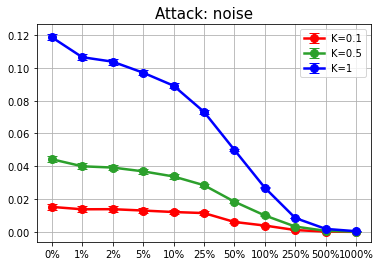

In [11]:
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for K in K_l[:-3]:
    ntk_l = ntk_dict[K]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"K={K}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

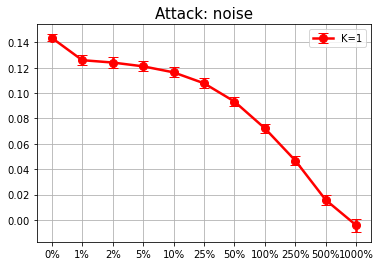

In [14]:
# T = 1
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for K in K_l:
    ntk_l = ntk_dict[K]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"K={K}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

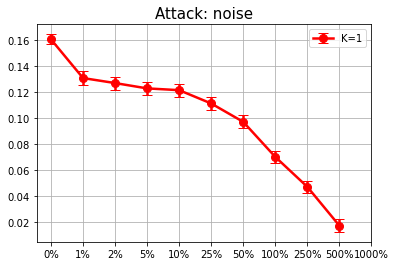

In [24]:
# T = 0.5
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for K in K_l:
    ntk_l = ntk_dict[K]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"K={K}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()

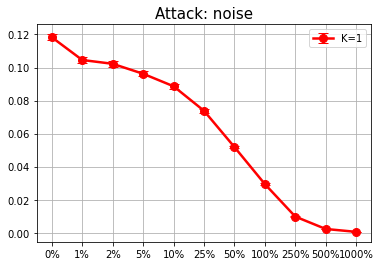

In [29]:
# T = 50
# T = 0.5
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for K in K_l:
    ntk_l = ntk_dict[K]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"K={K}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()